In [141]:
import acquire
import prep
import split_scale
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [2]:


# read sql data from csv to minimize lag
# df = pd.read_csv(r'/Users/mists/codeup-data-science/zillow-cluster/query_result.csv')
df = pd.read_csv(r'/Users/cris/codeup-data-science/zillow-cluster/query_result.csv')

In [3]:
# wrangle_zillow code here
df = acquire.wrangle_zillow(df)

In [4]:
df = prep.handle_missing_values(df,.90,.40)

In [5]:
df = prep.clean_columns(df)

In [6]:
df = prep.drop_minimal_nulls(df)

In [7]:
df = prep.pretty_cols(df)

In [8]:
df = prep.cal_taxrate(df)

In [9]:
df.transactiondate = pd.to_datetime(df.transactiondate)
df.countyid = df.countyid.astype("category")

In [10]:
train, test = split_scale.split_my_data(df, .80)

In [11]:
train, test = prep.impute_lotsize_nulls(train, test)

In [12]:
train = prep.cal_land_area(train)
test = prep.cal_land_area(test)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 15 columns):
countyid           41680 non-null category
latitude           41680 non-null int64
longitude          41680 non-null int64
yearbuilt          41680 non-null float64
bathroomcnt        41680 non-null float64
bedroomcnt         41680 non-null int64
house_area         41680 non-null float64
house_value        41680 non-null float64
land_value         41680 non-null float64
whole_area         41680 non-null float64
whole_value        41680 non-null float64
logerror           41680 non-null float64
transactiondate    41680 non-null datetime64[ns]
taxrate            41680 non-null float64
land_area          41680 non-null float64
dtypes: category(1), datetime64[ns](1), float64(10), int64(3)
memory usage: 6.1 MB


---

In [46]:
#transaction date is removed in train (for exploration purposes)
train_ex = train.copy()
train_ex = train_ex.drop(columns="transactiondate")

test_ex = test.copy()
test_ex = test_ex.drop(columns="transactiondate")

In [47]:
train_ex, test_ex, scaler = split_scale.iqr_robust_scaler(train_ex, test_ex)

trex is train:
    - without the transaction date
    - scaled to normal distribution

In [48]:
train_ex_home = train_ex[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area","yearbuilt"]]
train_ex_loc = train_ex[["logerror","latitude","longitude","countyid"]]
train_ex_val = train_ex[["logerror","house_value","land_value","whole_value","taxrate"]]

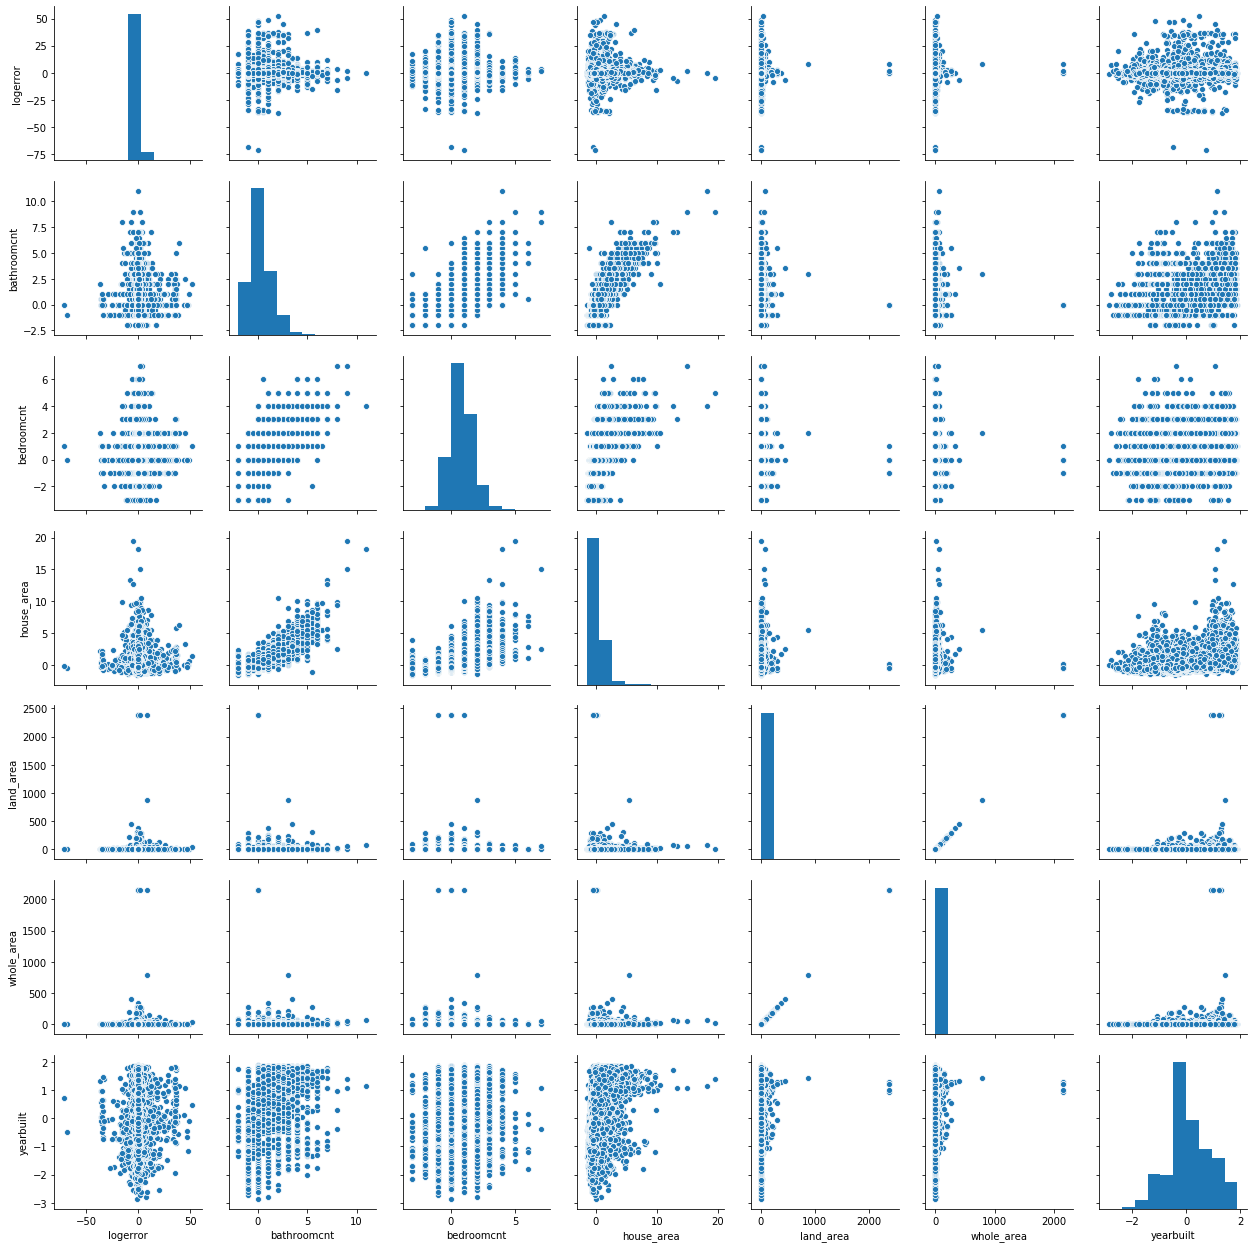

In [52]:
sns.pairplot(train_ex_home)

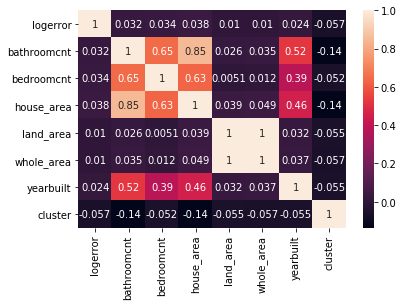

In [155]:
sns.heatmap(train_ex_home.corr(), annot=True)

`bathroomcnt` and `bedroomcnt` have strong positive correlation with `house_area`. These features can be dropped. Likewise, `land_area` is a derivative of the data we know previously which was `whole_area` (prev. lotsize) so they're very strongly correlated. We can drop the `whole_area` for now.
  
Recall that `land_area` is a derived feature from finished sqft and lot size. We inferred that a big house, does not always entail a big land which is why we separated land and house area in the first place. Seeing a low (0.15) correlation between `land_area` and `house_area` confirms that it was a good move to separate these features.
  
It's also interesting to note that `house_area` has a fairly strong positive correlation with `yearbuilt` and it's probably due to the style of house built during that era (craftsman, neoclassical, ranch style, etc.). Even if they are correlated, year built provides a distinct information on the property so we will keep it.

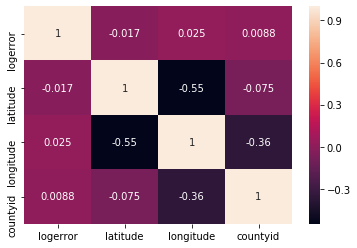

In [54]:
sns.heatmap(train_ex_loc.corr(),annot=True)

No correlations stand out from the house group, but it's worth noting that `latitude` and `longitude` have strong negative correlation. It means that as we move eastwards, we move southwards, which geographically makes sense as we are considering counties in Los Angeles (forms a downsloping diagonal line).

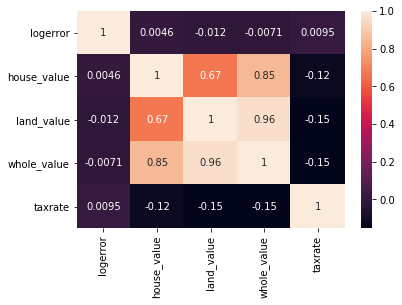

In [55]:
sns.heatmap(train_ex_val.corr(),annot=True)

`whole_value` is the sum of `land_value` and `house_value`, so a positive high correlation of .95 and .8 is expected. We can drop `whole_value` as a feature for the model.
  
The `tax_rate` having strong negative correlations with `land_value` is something to note.

<div class="alert alert-block alert-info">
<b>TAKEAWAY:</b>  
    
- None of the features seem to highly correlate with logerror. But it makes me think that its possibly because of two things:
    1. Logerror is a derived feature. It's not as straightforward as property value.
    2. Logerror is drived by a summation of different things, random and predictable. It's a multi-dimensional problem that needs more than x predicts y.
- Pearson's r does not show statistical significance. Instead of thinking that none of these features drive logerror, it strengthens the idea of exploring clustering more to address the dimensionality of the features.
- With the above being said, instead of using pearson's r to both (1) see strong drivers in explaining logerror, and (2) check for multicollinear features, we will only use it to address multicollinearity and inform us what features to drop.
- **Features to Keep based on Pearson's Correlation**
 - Home Group  
   - land_area  
   - house_area  
   - yearbuilt  
 - Location Group  
   - latitude  
   - longitude  
   - county_id  
 - Valuation Group  
   - house_value  
   - land_value  
   - taxrate  
</div>

---

In [130]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_ex_home[["logerror","land_area","house_area"]])

clusters = pd.DataFrame(kmeans.predict(train_ex_home[["logerror","land_area","house_area"]]))

[43384197.426250875]
[43384197.426250875, 3933876.684226408]
[43384197.426250875, 3933876.684226408, 1916385.2982971298]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248, 721313.6839595984]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248, 721313.6839595984, 583238.8915930843]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248, 721313.6839595984, 583238.8915930843, 472428.423611986]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248, 721313.6839595984, 583238.8915930843, 472428.423611986, 390473.236217069]
[43384197.426250875, 3933876.684226408, 1916385.2982971298, 1345158.5288125111, 894928.1518581248, 721313.6839595984,

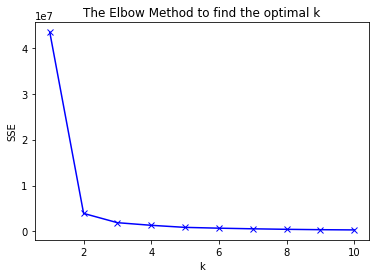

In [138]:
ks = range(1,11)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_ex_home[["logerror","land_area","house_area"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

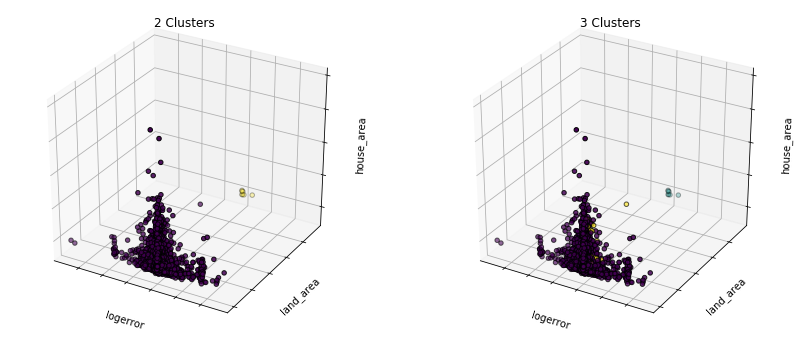

In [142]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_home[["logerror","land_area","house_area"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_home.logerror, 
               train_ex_home.land_area, 
               train_ex_home.house_area,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='logerror', ylabel='land_area', zlabel='house_area')
    ax.set(title=title)

In [151]:
train_ex_loc.groupby("countyid").count()

,logerror,latitude,longitude
countyid,,,
0.000000,26935,26935,26935
1.000000,11286,11286,11286
3.363636,3459,3459,3459


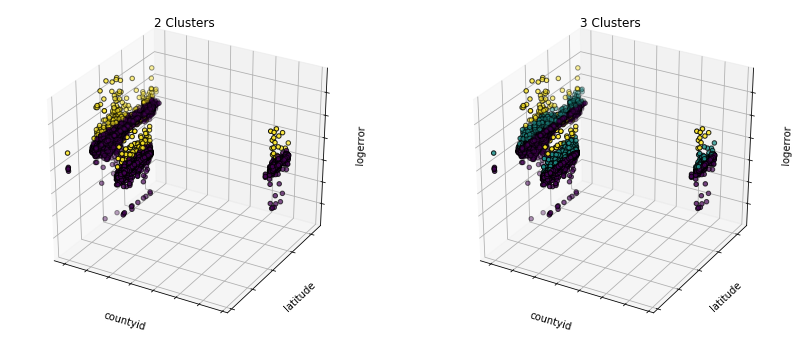

In [152]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_loc[["logerror","latitude","countyid"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_loc.countyid, 
               train_ex_loc.latitude, 
               train_ex_loc.logerror,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='countyid', ylabel='latitude', zlabel='logerror')
    ax.set(title=title)

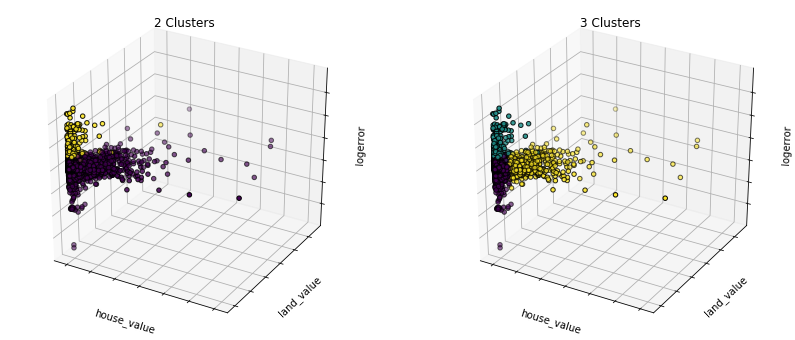

In [154]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_val[["logerror","house_value","land_value"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_val.house_value, 
               train_ex_val.land_value, 
               train_ex_val.logerror,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='house_value', ylabel='land_value', zlabel='logerror')
    ax.set(title=title)
    
#     train_ex_val = train_ex[["logerror","house_value","land_value","whole_value","taxrate"]]